<a href="https://colab.research.google.com/github/SergeiVKalinin/MSE_Fall2023/blob/main/Module%203/9_Clustering_graphene.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tutorial notebook for the Fall 2023 Course "Machine Learning for Materials Science", University of Tennessee Knoxville, Department of Materials Science and Engineering.

- Instructor Sergei V. Kalinin
- The dataset consists of 50 different STEM images of silicon in graphene.
- The dataset is initially passed through semantic segmentation DCNN network which classifies each pixel in an image into 3 different classes (C-atom, Si-atom, and background)
- Then we explore the strucutre of building blocks


In [1]:
# Download the dataset, Will explain what each file corresponds to later
!gdown https://drive.google.com/uc?id=1-JZSRjIjNjkR0ZQ8ffRDAZ2FID53Yhon
!gdown https://drive.google.com/uc?id=1-84vLdGFsimD1jaTcGcMzNRCSvjId7-Y
!gdown https://drive.google.com/uc?id=1-Lowglj7fwEFaJoC9EBKDyfCIsMgOnyu

Downloading...
From: https://drive.google.com/uc?id=1-JZSRjIjNjkR0ZQ8ffRDAZ2FID53Yhon
To: /content/3DStack13-1-dec.npy
100% 157M/157M [00:00<00:00, 170MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-84vLdGFsimD1jaTcGcMzNRCSvjId7-Y
To: /content/3DStack13-1-exp.npy
100% 52.4M/52.4M [00:00<00:00, 77.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-Lowglj7fwEFaJoC9EBKDyfCIsMgOnyu
To: /content/3DStack13-1-coord.npy
100% 2.45M/2.45M [00:00<00:00, 181MB/s]


In [2]:
# Installing AtomAI
# It will be used to split the image into local patches centered on atoms

!pip install atomai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.4/147.4 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 18.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 kB 20.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.1 MB/s eta 0:00:00
  Created wheel for matplotlib: filename=matplotlib-3.3.4-cp310-cp310-linux_x86_64.whl size=11684756 sha256=c7399d85648a16d6b676e3aecd98f19d04933a2c04ba674eebee3090e5a2f176
  Stored in directory: /root/.cache/pip/wheels/38/c6/49/eaba6d234887d98d9c85185e2a90bd7bb77934e85eefaf317e
  Created wheel for mendeleev: filename=mendeleev-0.6.1-py2.py3-none-any.whl size=174959 sha256=caefcff676e9403a0f73137ef53184c34d3827b46e7e64e50eb7949ab0

In [3]:
# Importing necessary packages
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# We will use atomai just to create the dataset (sub-images)
import atomai as aoi
import cv2
import torch
import torch.nn as nn

import seaborn as sns
from scipy import stats

tt = torch.tensor

In [4]:
STEM_real = np.load('3DStack13-1-exp.npy')   # raw STEM Image
decoded_imgs = np.load('3DStack13-1-dec.npy')   # oytput of DCNN where the each pixel is classified as one of the three classes (C, Si, or background)
lattice_coord = np.load('3DStack13-1-coord.npy', allow_pickle=True)[()]  # The atomic coodinates found by DCNN

For the ease of analysis, let's make the movie shorter

Text(0.5, 1.0, 'Atomic coordinates')

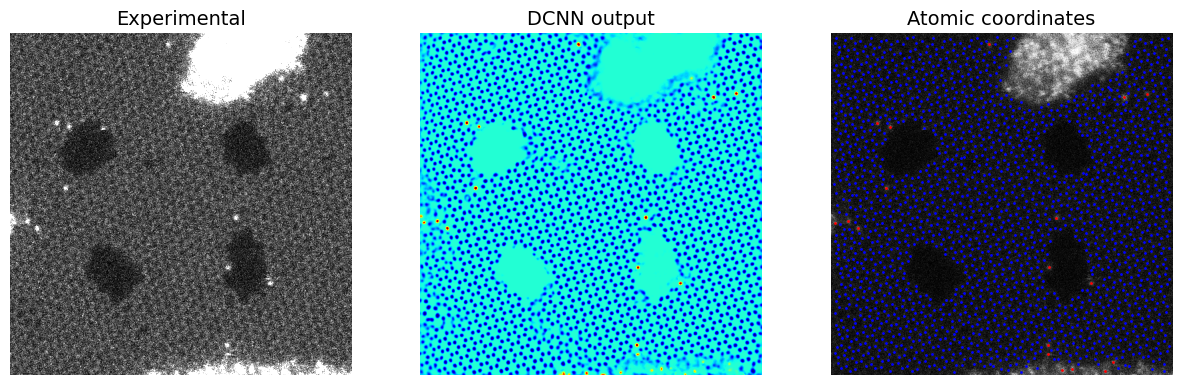

In [5]:
#Vizualizing one frame of the data, we have 50 frames (0-49)

i = 3 # Choose movie frame

# Squeeze the channels in the predicted image (this is optional)
d_img = np.uint8(decoded_imgs[i]*255)
d_img = cv2.cvtColor(d_img, cv2.COLOR_BGR2GRAY)

# Get coordinates for C and Si atoms
lattice_coord_ = lattice_coord[i]
coord_Si = lattice_coord[i][np.where(lattice_coord[i][:,2]==1)][:,0:2]
coord_C = lattice_coord[i][np.where(lattice_coord[i][:,2]==0)][:,0:2]

# Plotting
fig = plt.figure(figsize = (15, 10), dpi = 100)
ax1 = fig.add_subplot(131)
ax1.imshow(STEM_real[i,:,:,0], vmin=0, vmax=0.3, cmap='gray')
ax1.axis('off')
ax1.set_title('Experimental', fontsize=14)
ax2 = fig.add_subplot(132)
ax2.imshow(d_img, cmap='jet', interpolation='Gaussian')
ax2.axis('off')
ax2.set_title('DCNN output', fontsize = 14)
ax3 = fig.add_subplot(133)
ax3.scatter(coord_Si[:,1], coord_Si[:,0], c='red', s=1)
ax3.scatter(coord_C[:,1], coord_C[:,0], c='blue', s=1)
ax3.imshow(STEM_real[i,:,:,0], cmap = 'gray')
ax3.axis('off')
ax3.set_title('Atomic coordinates', fontsize = 14)

In [6]:
# Getting feature vectors
# Feature vectors here are the cropped images around the coordinates found by DCNN. The window_size of these cropped images can be changed below

window_size = 40   # Window_size

s = aoi.stat.imlocal(
    np.sum(decoded_imgs[..., :-1], -1)[..., None], # convert to a single channel (no background)
    lattice_coord, # Coodinates array, acts as the mid-point of the cropped sub-images
    window_size, 0)

In [7]:
#Setting the train loader

imstack = tt(s.imgstack[:,None,:,:, 0])

# train_loader_graphene = pv.utils.init_dataloader(imstack, batch_size=50)
frames_all = s.imgstack_frames # will need for plotting VAE results
com_all = s.imgstack_com # will need for plotting VAE results

In [8]:
imstack.shape, frames_all.shape, com_all.shape

(torch.Size([73995, 1, 40, 40]), (73995,), (73995, 2))

In [9]:
np.unique(frames_all)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

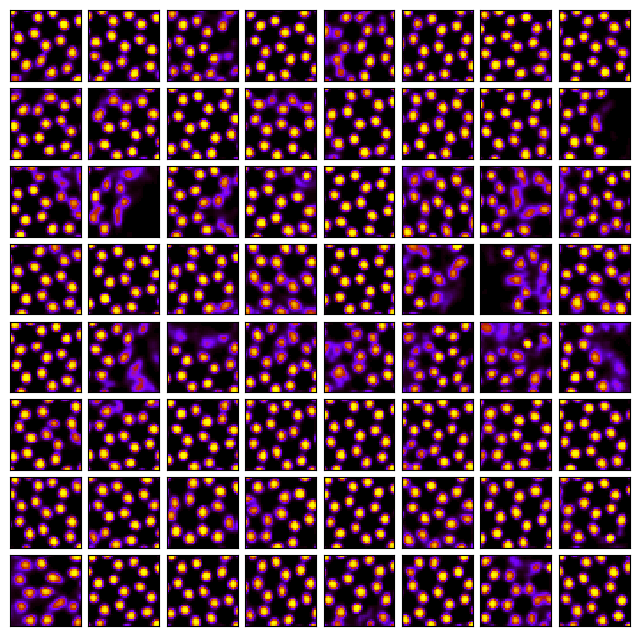

In [10]:
# Vizualizing the training dataset

np.random.seed(1)  # fix seed so that we get the same samples displayed at every run
fig, axes = plt.subplots(8, 8, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(imstack))
    ax.imshow(imstack[i, 0], cmap='gnuplot', interpolation='nearest')

# plt.savefig('example_imgs.png', dpi = 300)

We can check the sizes of all objects we have created

In [11]:
imstack.shape

torch.Size([73995, 1, 40, 40])

In [12]:
imstack1 = imstack[frames_all == 1]
com_all1 = com_all[frames_all == 1]
imstack1.shape, com_all1.shape

(torch.Size([1798, 1, 40, 40]), (1798, 2))

And run the k-means clustering

In [13]:
from sklearn.cluster import KMeans

a, b, c, d = imstack1.shape
imstack2 = imstack1.reshape(a, c * d)

nc = 3
km = KMeans(n_clusters=nc, random_state=0)
y_km = km.fit_predict(imstack2)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


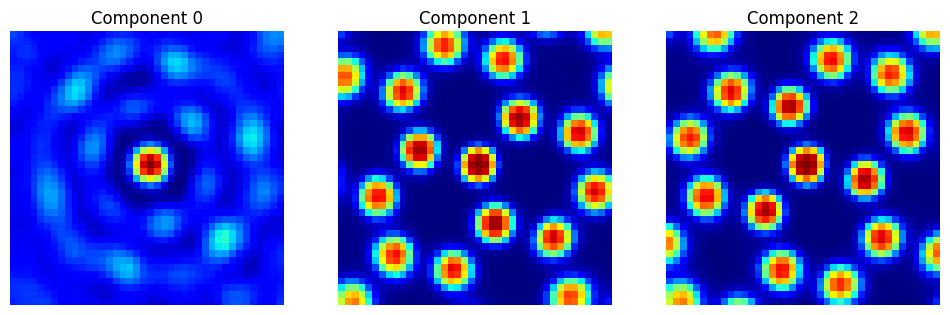

In [14]:
rows = int(np.ceil(float(nc)/5))
cols = int(np.ceil(float(nc)/rows))

gs2 = gridspec.GridSpec(rows, cols)

fig2 = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))

for i in range(nc):
    ax2 = fig2.add_subplot(gs2[i])
    ax2.imshow(km.cluster_centers_[i,:].reshape(c, d), cmap = 'jet', origin = 'lower')
    ax2.set_title('Component ' + str(i))
    plt.tick_params(labelsize = 18)
    plt.axis('off')
plt.show()

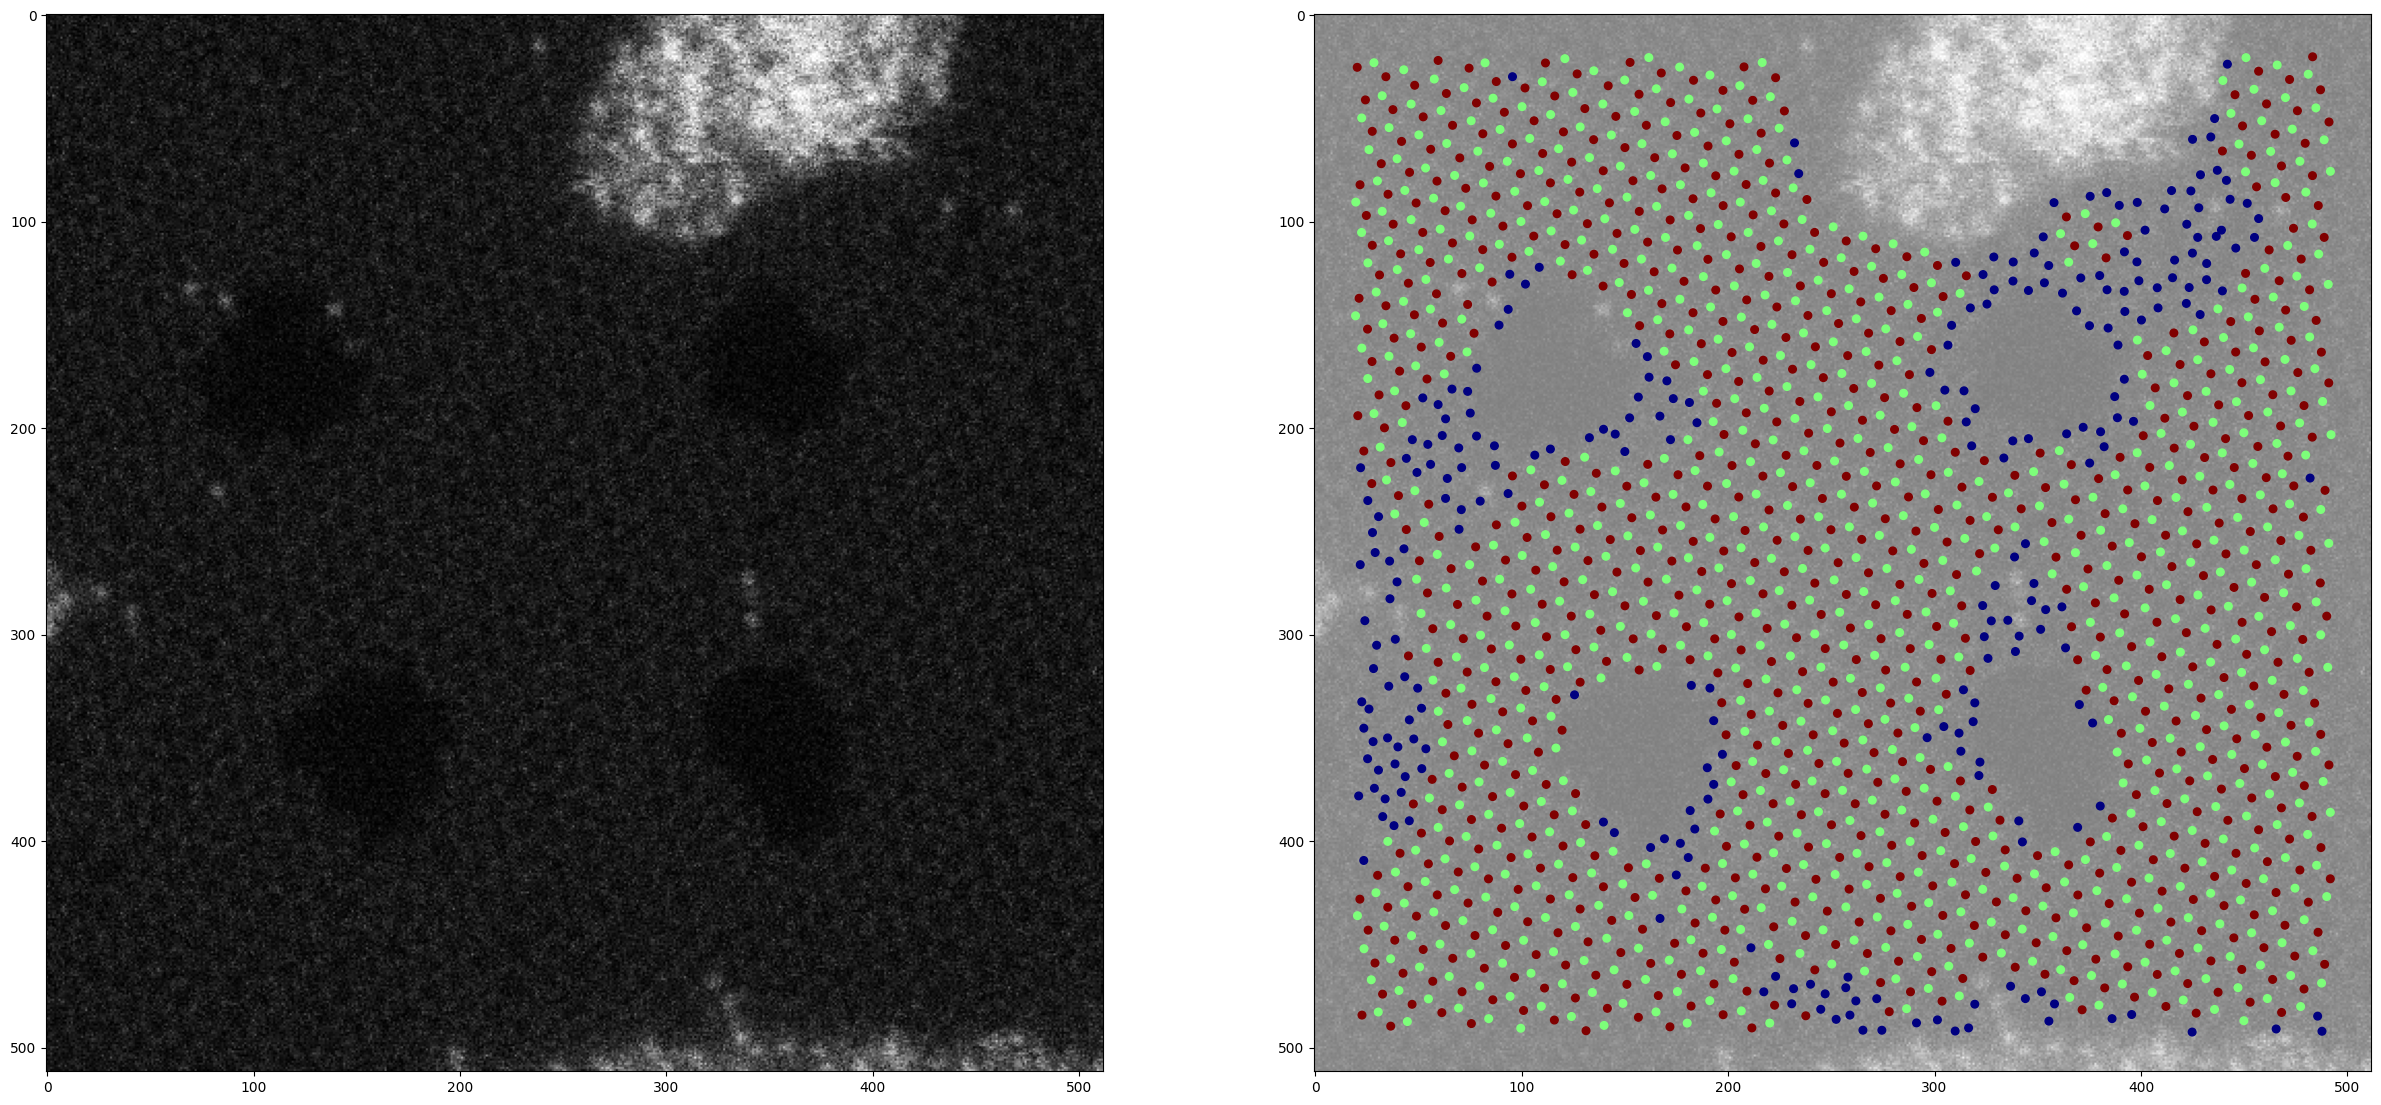

In [15]:
#Visualizing the cluster labels on the raw STEM image

fig, ax = plt.subplots(1, 2, figsize=(30, 15))

ax[0].imshow(STEM_real[i,...,0], cmap="gray")
ax[1].imshow(STEM_real[i,...,0], cmap="gray", alpha = 0.5)
ax[1].scatter(com_all1[:, 1], com_all1[:, 0], c=y_km, s=30, cmap="jet")

plt.show()

In [16]:
from sklearn.mixture import GaussianMixture as GMM

a, b, c, d = imstack1.shape
imstack2 = imstack1.reshape(a, c * d)

nc = 8
gmm = GMM(n_components=nc).fit(imstack2)
gr_labels = gmm.predict(imstack2)
gr_centers = gmm.means_

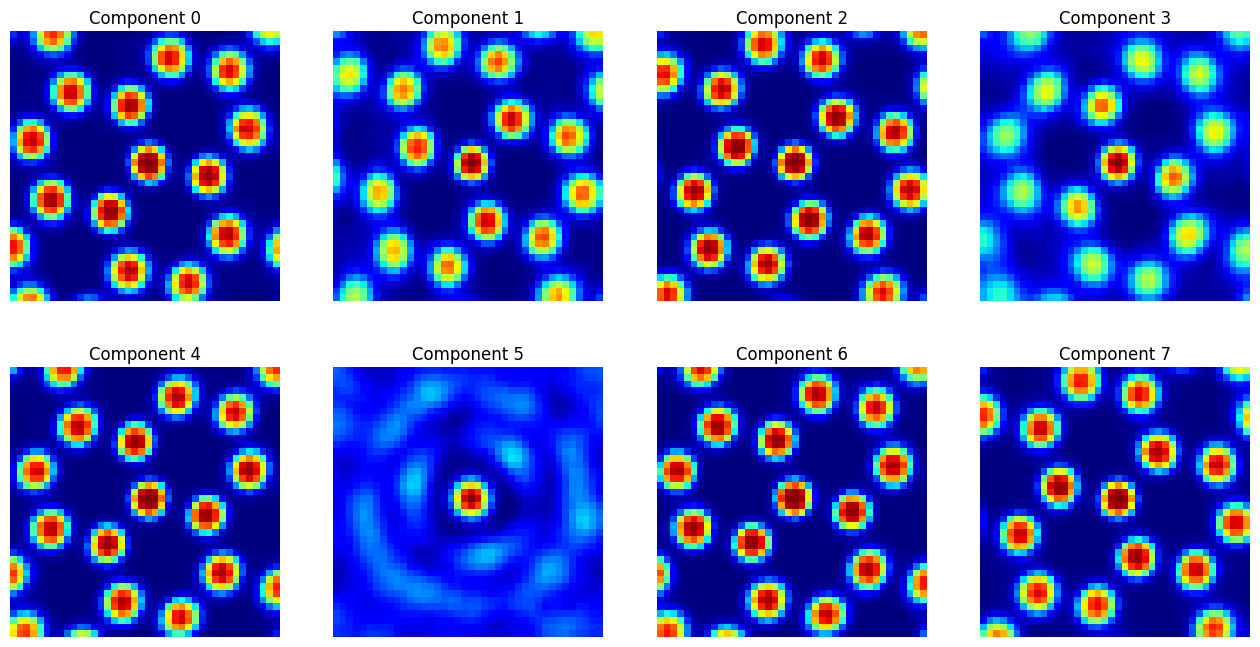

In [17]:
rows = int(np.ceil(float(nc)/5))
cols = int(np.ceil(float(nc)/rows))

gs2 = gridspec.GridSpec(rows, cols)

fig2 = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))

for i in range(nc):
    ax2 = fig2.add_subplot(gs2[i])
    ax2.imshow(gr_centers[i,:].reshape(c, d), cmap = 'jet', origin = 'lower')
    ax2.set_title('Component ' + str(i))
    plt.tick_params(labelsize = 18)
    plt.axis('off')
plt.show()

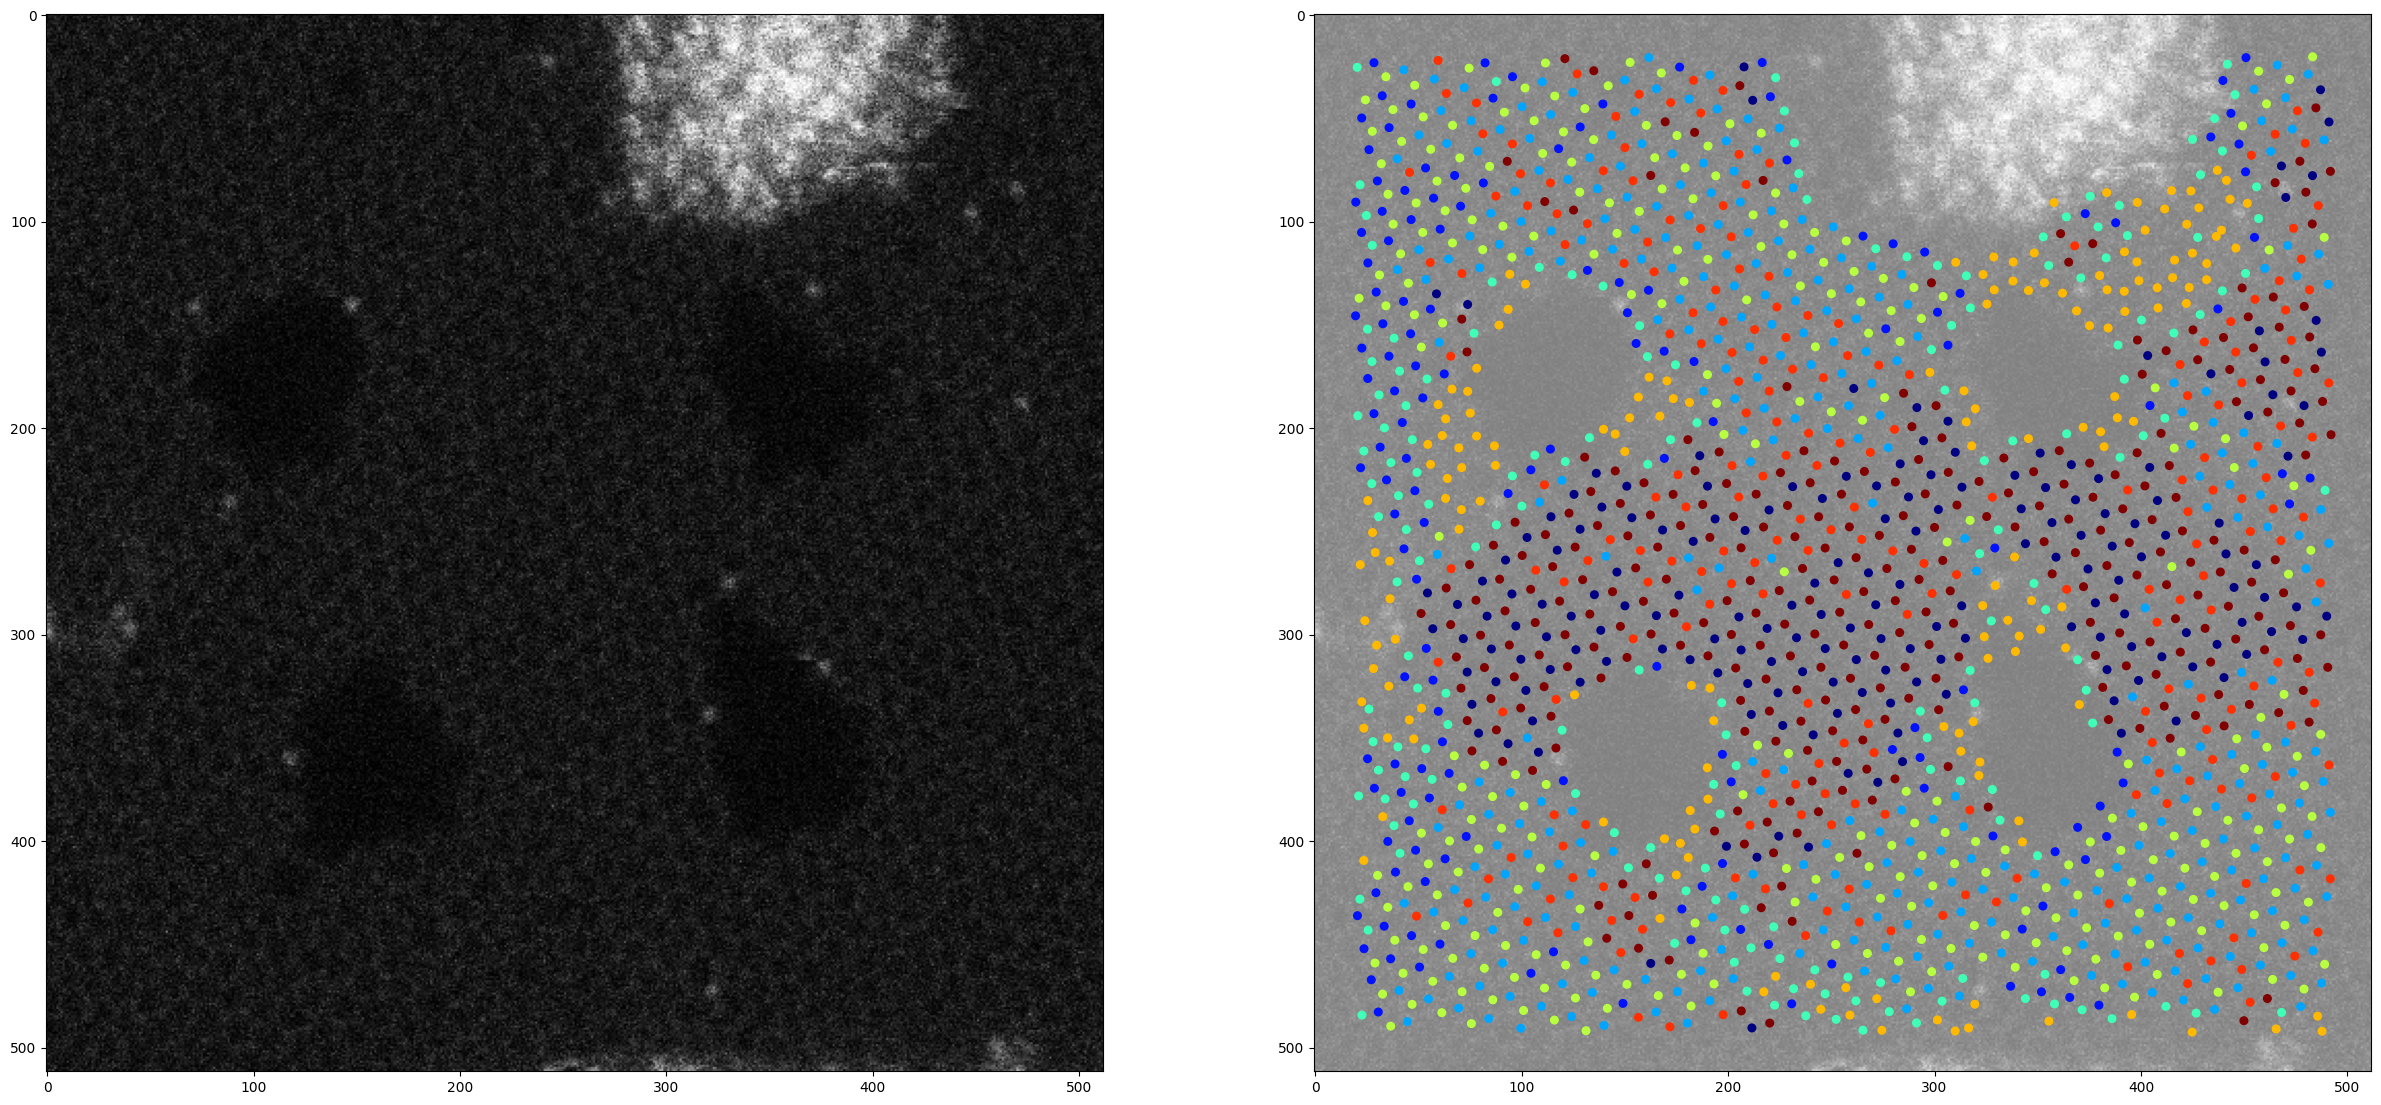

In [18]:
#Visualizing the cluster labels on the raw STEM image

fig, ax = plt.subplots(1, 2, figsize=(30, 15))

ax[0].imshow(STEM_real[i,...,0], cmap="gray")
ax[1].imshow(STEM_real[i,...,0], cmap="gray", alpha = 0.5)
ax[1].scatter(com_all1[:, 1], com_all1[:, 0], c=gr_labels, s=30, cmap="jet")

plt.show()